In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [108]:
#data = pd.read_csv('microsoftdata.csv')
#data = pd.read_csv('Tesla_Stock_Updated_V2_2.csv') 
data = pd.read_csv('goldstock_2.csv') 
data = data.rename(columns={'Close(t)':'Close'})

data.head()


,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,1/19/2024,2029.3,166078,2027.4,2041.9,2022.2
1,1,1/18/2024,2021.6,167013,2009.1,2025.6,2007.7
2,2,1/17/2024,2006.5,245194,2031.7,2036.1,2004.6
3,3,1/16/2024,2030.2,277995,2053.4,2062.8,2027.6
4,4,1/12/2024,2051.6,250946,2033.2,2067.3,2033.1


In [109]:
# Replace the column name 'Price' to 'Close'
#if 'Price' in data.columns:
    #data = data.rename(columns={'Price': 'Close'})

In [110]:
data.tail(5)

,Unnamed: 0,Date,Close,Volume,Open,High,Low
258,258,1/9/2023,1877.8,183869,1872.8,1886.4,1869.3
259,259,1/6/2023,1869.7,208187,1835.9,1875.2,1835.2
260,260,1/5/2023,1840.6,177851,1861.2,1864.3,1829.9
261,261,1/4/2023,1859.0,193760,1845.2,1871.3,1842.0
262,262,1/3/2023,1846.1,206818,1831.8,1856.6,1831.3


In [111]:
# Calculate the 50-day moving average
data['50_MA'] = data['Close'].rolling(window=50).mean()

# Calculate the 20-day Bollinger Band
data['20_STD'] = data['Close'].rolling(window=20).std()
data['Upper_Band'] = data['High'] + 2 * data['20_STD']
data['Lower_Band'] = data['Low'] - 2 * data['20_STD']

# Calculate previous low and high
data['Prev_Low'] = data['Low'].shift(-1)
data['Prev_High'] = data['High'].shift(-1)

# Generate buy and sell signals using Aroon
data['aroon_bull'] = 100 * data['High'].rolling(window=14).apply(lambda x: x.argmax()) / 14
data['aroon_bear'] = 100 * data['Low'].rolling(window=14).apply(lambda x: x.argmin()) / 14

data['Buy_Signal'] = np.where((data['Close'] > data['50_MA']) & (data['aroon_bull'] > data['aroon_bear']), 1, 0)
data['Sell_Signal'] = np.where((data['Close'] < data['50_MA']) & (data['aroon_bear'] > data['aroon_bull']), -1, 0)

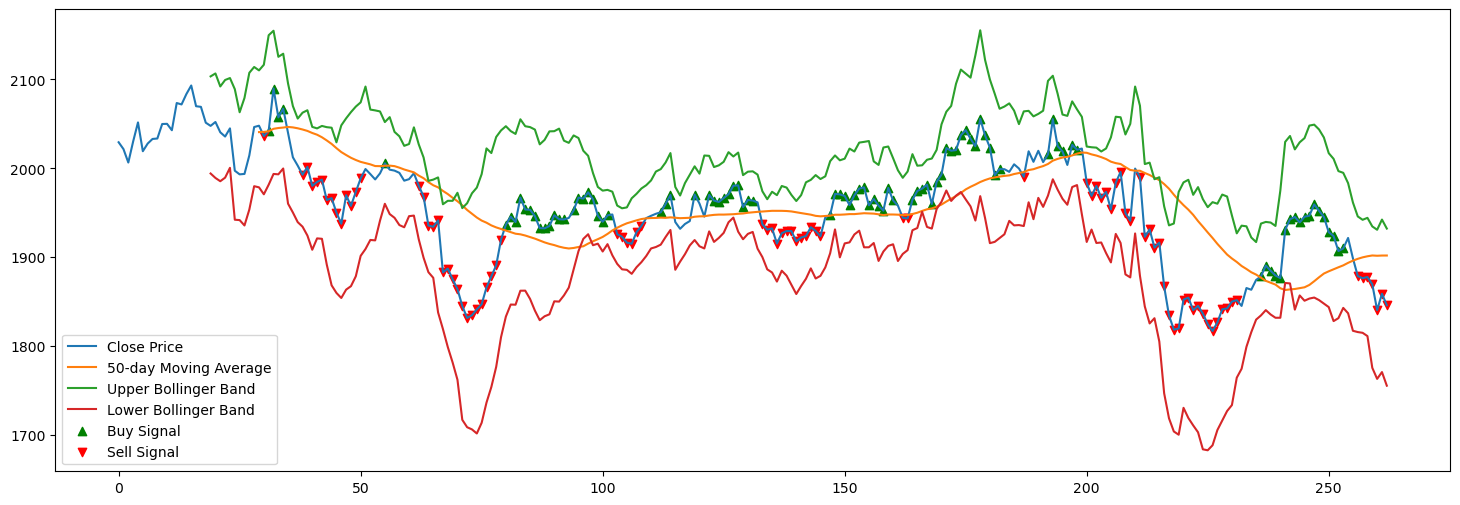

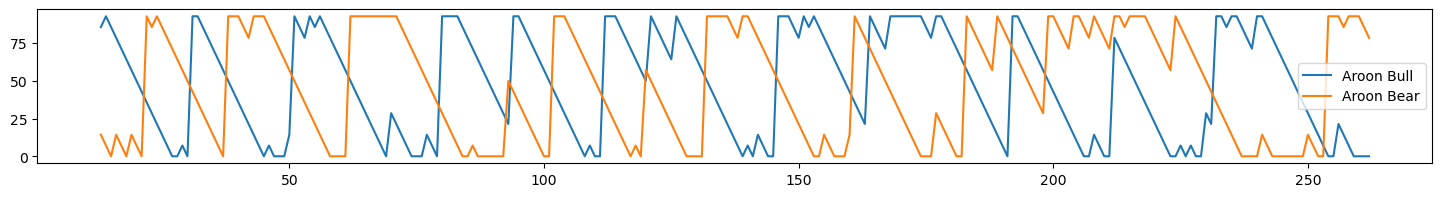

In [112]:
# Plot Figure 1
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(data['Close'], label='Close Price')
ax1.plot(data['50_MA'], label='50-day Moving Average')
ax1.plot(data['Upper_Band'], label='Upper Bollinger Band')
ax1.plot(data['Lower_Band'], label='Lower Bollinger Band')
ax1.scatter(data.index[data['Buy_Signal'] == 1], data['Close'][data['Buy_Signal'] == 1], color='green', marker='^', label='Buy Signal')
ax1.scatter(data.index[data['Sell_Signal'] == -1], data['Close'][data['Sell_Signal'] == -1], color='red', marker='v', label='Sell Signal')
ax1.legend()
plt.show()

# Plot Figure 2
fig, ax2 = plt.subplots(figsize=(18, 2))

ax2.plot(data['aroon_bull'], label='Aroon Bull')
ax2.plot(data['aroon_bear'], label='Aroon Bear')
ax2.legend()
plt.show()

In [113]:
# Prepare the data for modeling
data['Tomorrows Close'] = data['Close'].shift(1)
features = ['Close', 'Buy_Signal', 'Sell_Signal', '50_MA', 'Upper_Band', 'Lower_Band']
X = data[features].iloc[1:, :]
y = data['Tomorrows Close'].dropna()


In [114]:

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
# Handle missing values in the training and test sets
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)


In [116]:

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [117]:
# Predictions for the training data
y_train_pred = model.predict(X_train_scaled)

# Evaluate the model on the training data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

print("_")
print("Train MSE:", mse_train)
print("_")
print("RMSE:", rmse_train)
print("_")
print("R-squared:", r2_train)
print("_")
print("MAE:", mae_train)
print("_")


_
Train MSE: 41.5281505071764
_
RMSE: 6.444233896063705
_
R-squared: 0.9881026866625936
_
MAE: 4.845110047846813
_


In [118]:

# Predictions
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("_")
print("Test MSE:", mse_test)
print("_")
print("RMSE:", rmse_test)
print("_")
print("R-squared:", r2_test)
print("_")
print("MAE:", mae_test)
print("_")

_
Test MSE: 442.9215716792428
_
RMSE: 21.04570197639515
_
R-squared: 0.8936312726493896
_
MAE: 16.73122641509423
_


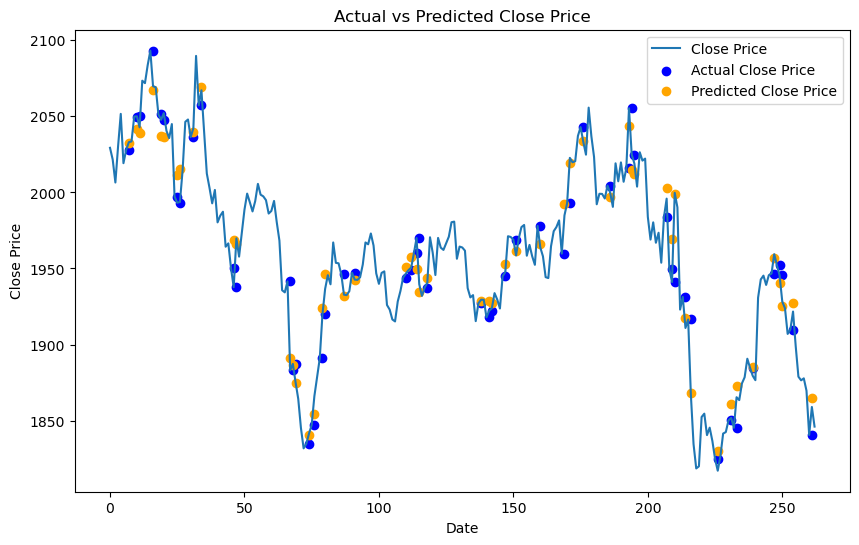

In [119]:
# Create a DataFrame with actual and predicted values for plotting
df_plot = pd.DataFrame({
    'Actual Close Price': y_test,
    'Predicted Close Price': y_test_pred
})

# Print the DataFrame
#print(df_plot)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.scatter(df_plot.index, df_plot['Actual Close Price'], label='Actual Close Price', color='blue', marker='o')
plt.scatter(df_plot.index, df_plot['Predicted Close Price'], label='Predicted Close Price', color='orange', marker='o')
plt.xlabel('Date') 

plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

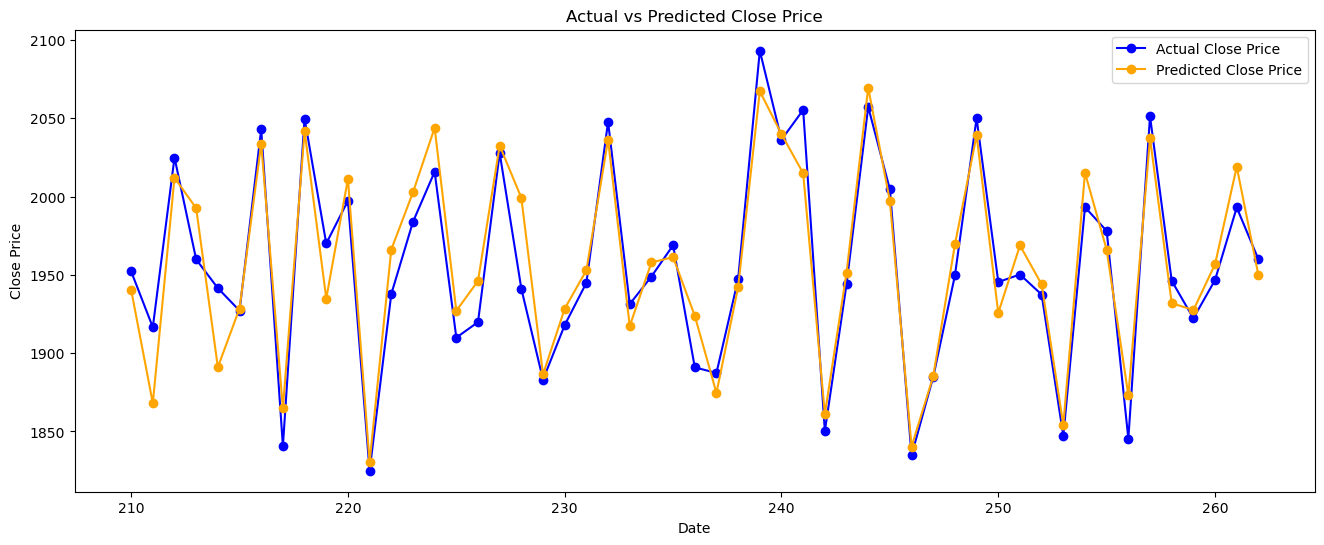

In [120]:

# Create a DataFrame with actual and predicted values for plotting
df_plot = pd.DataFrame({
    'Date': data.index[-len(X_test):],
    'Actual Close Price': y_test,
    'Predicted Close Price': y_test_pred
})

# Plot actual vs predicted values
plt.figure(figsize=(16, 6))
plt.plot(df_plot['Date'], df_plot['Actual Close Price'], label='Actual Close Price', color='blue', marker='o')
plt.plot(df_plot['Date'], df_plot['Predicted Close Price'], label='Predicted Close Price', color='orange', marker='o')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()